Mono/train/4.jpg
4
Mono/train/5.jpg
5
Mono/train/6.jpg
6
Mono/train/2.jpg
2
Mono/train/3.jpg
3
Mono/test/1.jpg
1
['1', 'jpg']
4361
0.6547420024871826
4


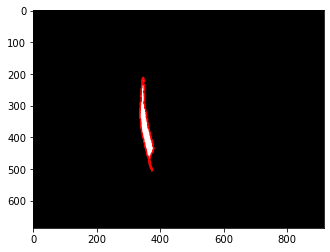

In [7]:
# import

import numpy as np
import cv2
import pandas as pd
import skimage
from skimage.filters import roberts, sobel, scharr, prewitt
from sklearn import metrics
import time
import glob
import pickle
from matplotlib import pyplot as plt
from scipy.stats import mode
from scipy import ndimage
import shutil
from skimage import measure
from sklearn.metrics import confusion_matrix
import lightgbm as lgb
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier

# feature extraction function

def feature_extractor(img):
    df = pd.DataFrame()
    df2 = pd.DataFrame()
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)
    h=h.reshape(-1)
    s=s.reshape(-1)
    v=v.reshape(-1)
    df['h']=h
    df['s']=s
    df['v']=v
    
    img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    img2 = img.reshape(-1)
    df['grayscale'] = img2
    
    from skimage.filters import scharr, prewitt
    scharr = scharr(img)
    scharr= scharr.reshape(-1)
    df['scharr'] = scharr

    prewitt = prewitt(img)
    prewitt = prewitt.reshape(-1)
    df['prewitt'] = prewitt

    from scipy import ndimage as nd
    gaussian3 = nd.gaussian_filter(img, sigma=3)
    gaussian3 = gaussian3.reshape(-1)
    df['G3'] = gaussian3

    gaussian7= nd.gaussian_filter(img, sigma=7)
    gaussian7 = gaussian7.reshape(-1)
    df['G7'] = gaussian7
    return df

# make a data frame

def make_dfimg(img,label):
    df = pd.DataFrame()
    df = feature_extractor(img)
    label = cv2.cvtColor(label, cv2.COLOR_BGR2GRAY)
    label[label>0]=1
    label = label.reshape(-1)
    df['Labels'] = label
    return df

# Data frame generator

def img_lab(img_path):
    df = pd.DataFrame()
    for file in glob.glob(img_path):
        print(file)
        print(file.split('/')[2].split('.')[0])
        img= cv2.imread(file)
        img = cv2.resize(img, (int(img.shape[0]/4),int(img.shape[1]/4)))
        labeled_img = cv2.imread('Mask/'+file.split('/')[2].split('.')[0]+'_Mono.ome.tiff')
        labeled_img = cv2.resize(labeled_img, (int(labeled_img.shape[0]/4),int(labeled_img.shape[1]/4)))
        df1 = make_dfimg(img,labeled_img)
        df = pd.concat([df,df1])

    return df


def evaluation_metric(cm):
    precision = cm[1,1]/(cm[0,1]+cm[1,1])
    recall = cm[1,1]/(cm[1,0]+cm[1,1])
    accuracy = (cm[0,0]+cm[1,1])/(cm[0,0]+cm[0,1]+cm[1,1]+cm[1,0])
    f1score = 2*(precision*recall)/(precision+recall)
    return precision,recall,accuracy,f1score


img_path = "Mono/train/*.jpg" # define the path
df_train = img_lab(img_path)

img_path = "Mono/test/*.jpg" # define the path
df_test = img_lab(img_path)

X_train = df_train.drop(labels = ["Labels"], axis=1) 
Y_train = df_train["Labels"].values
X_test = df_test.drop(labels = ["Labels"], axis=1) 
Y_test = df_test["Labels"].values

xgb_clf = xgb.XGBClassifier()
xgb_clf.fit(X_train,Y_train)

# RF = RandomForestClassifier(n_estimators = 100, random_state = 2022,n_jobs = -1)
# RF.fit(X_train, Y_train)

# clf = lgb.LGBMClassifier(n_estimators=400,learning_rate=0.005)
# eval_set = [(X_train, Y_train), (X_test, Y_test)]
# clf.fit(X_train,Y_train,eval_metric='binary',eval_set=eval_set,verbose=False,early_stopping_rounds=100)

# from sklearn.tree import DecisionTreeClassifier
# DT = DecisionTreeClassifier(random_state=42)
# DT.fit(X_train, Y_train)


t1=time.time()

# 그래핀을 찾고자 하는 사진의 path를 정의
img_path = "Mono/test/*.jpg" # img path 

# 폴더안의 모든 사진에 대해 for loop로 탐색
for file in glob.glob(img_path)[:]:
    print(file.split('/')[-1].split('.'))
    img1 = cv2.imread(file)
#    img_0 = img1
    img1 = cv2.resize(img1, (int(img1.shape[0]/2),int(img1.shape[1]/2))) 
    feature = feature_extractor(img1)
    img = cv2.cvtColor(img1,cv2.COLOR_BGR2GRAY)

    
    ####### 머신러닝 알고리즘 적용########
    result = RF.predict(feature)
    
#     result = xgb_clf.predict(feature)    
#     result = RF.predict(feature)
#     result = clf.predict(feature)
#     result = DT.predict(feature)
    segmented_img = result.reshape((img.shape))
    segmented_img = cv2.resize(segmented_img, (int(img1.shape[1]),int(img1.shape[0])))

#     a = np.where(segmented_img>0)
#     wo = np.unique(a[0],return_counts=True)[0]
#     on = wo[np.unique(a[0],return_counts=True)[1]<5]
#     wo2 = np.unique(a[1],return_counts=True)[0]
#     on2 = wo2[np.unique(a[1],return_counts=True)[1]<5]


#     open_img = ndimage.binary_opening(segmented_img)
    segmented_img = ndimage.binary_closing(segmented_img)

    print(np.count_nonzero(segmented_img))
    if np.count_nonzero(segmented_img)>10:
        plt.imsave('test'+file.split('/')[-1].split('.')[0]+'.png', segmented_img, cmap ='gray') # set the image save path.

print(time.time()-t1)

img_path_mask = f"Mask/{file.split('/')[-1].split('.')[0]}_Mono.ome.tiff"


original_mask = cv2.imread(glob.glob(img_path_mask)[:][0])
original_mask = cv2.resize(original_mask, (int(img1.shape[1]),int(img1.shape[0])))
original_mask = cv2.cvtColor(original_mask,cv2.COLOR_BGR2GRAY)





plt.imshow(segmented_img,cmap='gray')

test_list = []


###### Contour finding code #########


for i in range(len(measure.find_contours(segmented_img,0))):
    xmax = max(measure.find_contours(segmented_img,0)[i][:,1])-min(measure.find_contours(segmented_img,0)[i][:,1])
    ymax = max(measure.find_contours(segmented_img,0)[i][:,0])-min(measure.find_contours(segmented_img,0)[i][:,0])
    
    if (xmax >= 30) and (ymax >= 30): 
        plt.plot(measure.find_contours(segmented_img,0)[i][:,1],measure.find_contours(segmented_img,0)[i][:,0],c='r')
        print(i)
        test_list.append(i)

img = np.zeros( (686,916) )

stencil_final = np.zeros(img.shape).astype(img.dtype)

color = [255, 255, 255] #random value for fillPoly

for i in test_list:
    
    stencil = np.zeros(img.shape).astype(img.dtype)
    contours = measure.find_contours(segmented_img,0)[i]
    contours = contours.astype(int)

    contours_t = contours.copy()
    temp = contours[:,0]
    contours_t[:,0] = contours[:,1]
    contours_t[:,1] = temp

    cv2.fillPoly(stencil, pts = [contours_t],color= color)
    stencil_final += stencil
    
plt.imshow(stencil_final,cmap ='gray')

test = original_mask.flatten()
test[original_mask.flatten()>0] = 255

# cm_test = confusion_matrix(test,stencil_final.flatten())
# precision,recall,accuracy,f1score = evaluation_metric(cm_test)
# save_praf.append([precision,recall,accuracy,f1score ])
# print(precision,recall,accuracy,f1score )

